In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# LSTMs and GRUs: More Structure in the Network

Why add structure?
1. Vanishing and exploding gradients - clipping can help with exploding gradients, but vanishing gradients make it hard to learn long-term dependencies
2. Introduce more non-linearity - with a "vanilla" RNN the combined input at time $t$ is the weighted sum of $x_t$ (input) and $h_{t-1}$ which is linear

All code below is directly from the textbook. We will be looking at the structure of LSTMs and GRUs and assessing whether they are better at language modeling than "vanilla" RNNs.



## Review: RNN

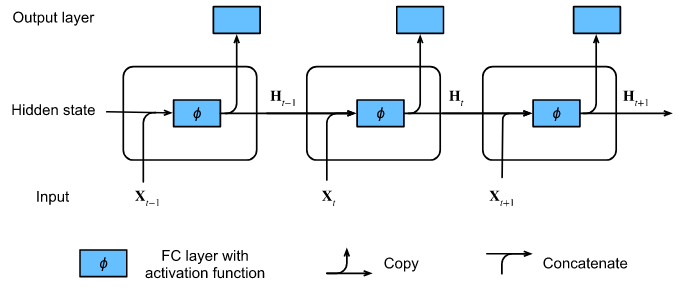

In [ ]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)
    
class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
rnnmodel = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(rnnmodel, data)
rnnmodel.predict('it has', 20, data.vocab)

## Memory cell

A memory cell is kind of like a mini-neural network with a super-specific organization. Once you have the cell (the mini-neural network) you can lay out cells as you would traditional neurons.

## LSTM memory cell

Your job, looking at the code below, is to fill in the teal zones.
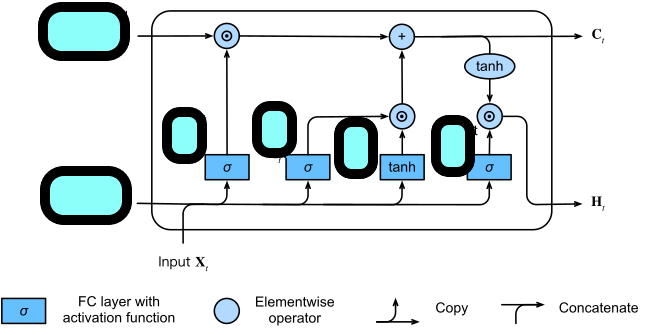

Use this list of variables:
* $X_t$ - input at time $t$
* $H_{t-1}$ - hidden state at time $t-1$
* $W_{xi}$ - weights for the input to the "input gate"
* $W_{hi}$ - weights for the hidden state to the "input gate"
* $W_{xf}$ - weights for the input to the "forget gate"
* $W_{hf}$ - weights for the hidden state to the "forget gate"
* $W_{xo}$ - weights for the input to the "output gate"
* $W_{ho}$ - weights for the hidden state to the "output gate"
* $b_i$ - bias for the "input gate"
* $b_f$ - bias for the "forget gate"
* $b_o$ - bias for the "output gate"
* $n$ - batch size
* $d$ - number of inputs

1. What is $I_t$, how is it  calculated, and what is its shape? $\sigma(X_t*W_{xi} + H_{t-1}*W_{hi} + b_i)$
2. What is $F_t$, how is it  calculated, and what is its shape? $\sigma(X_t*W_{xf} + H_{t-1}*W_{hf} + b_f)$
3. What is $O_t$, how is it  calculated, and what is its shape? $\sigma(X_t*W_{xo} + H_{t-1}*W_{ho} + b_o)$

Let's not forget $\tilde{C}_t$, $tanh(X_t*W_{xc} + H_{t-1}*W_{hc} + b_c)$

4. What is $C_t$, how is it calculated, and what is its shape? $\sigma(F_t*C_t + I_t*\tilde{C}_t)$

5. What activation functions are commonly used in a LSTM memory cell? sigmoid and tanh

In [ ]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                            torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)
    
    

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
lstmmodel = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(lstmmodel, data)
lstmmodel.predict('it has', 20, data.vocab)

## GRU memory cell

Your job, looking at the code below, is to fill in the teal zones.

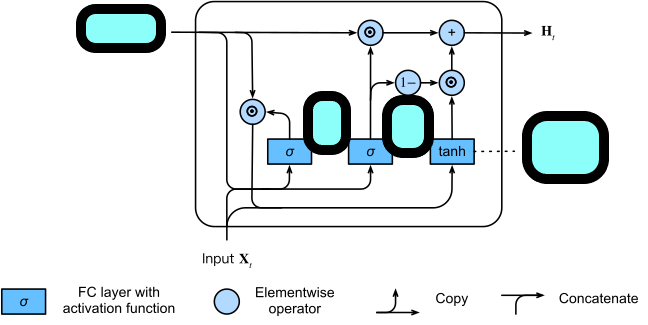

Use this list of variables:
* $X_t$ - input at time $t$
* $H_{t-1}$ - hidden state at time $t-1$
* $W_{xr}$ - weights for the input to the "reset gate"
* $W_{hr}$ - weights for the hidden state to the "reset gate"
* $W_{xz}$ - weights for the input to the "update gate"
* $W_{hz}$ - weights for the hidden state to the "update gate"
* $b_r$ - bias for the "reset gate"
* $b_z$ - bias for the "update gate"
* $n$ - batch size
* $d$ - number of inputs

1. What is $R_t$, how is it calculated, and what is its shape?
2. What is $Z_t$, how is it  calculated, and what is its shape?
4. What is $H_t$, how is it calculated, and what is its shape?
5. What activation functions are commonly used in a GRU memory cell?

What is the advantage of a GRU over a LSTM?

In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
        return outputs, H

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
grumodel = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(grumodel, data)
grumodel.predict('it has', 20, data.vocab)

In [ ]:
print(rnnmodel.predict('the boy who had grown up in ma went', 20, data.vocab))
print(lstmmodel.predict('the boy who had grown up in ma went', 20, data.vocab))
print(grumodel.predict('the boy who had grown up in ma went', 20, data.vocab))